In [2]:
import os
import random 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook,tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Lambda, RepeatVector, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau,TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!mv images test/images

In [0]:
im_width = 128
im_height = 128

border = 5

train_path = "/content/train/"
test_path = "/content/test/"

In [4]:
def get_data(path,train=True):
    ids = next(os.walk(path+"images"))[2]
    X = np.zeros((len(ids),im_height,im_width,1), dtype = np.float32)
    
    if train:
        y = np.zeros((len(ids),im_height,im_width,1), dtype=np.float32)
    print("Getting and Resizing images ...")
    for n,id_ in tqdm_notebook(enumerate(ids),total=len(ids)):
        img = load_img(path+"images/"+ id_,grayscale=True)
        x_img = img_to_array(img)
        x_img = resize(x_img,(128,128,1),mode = "constant",preserve_range=True)
        
        if train:
            mask = img_to_array(load_img(path+"masks/"+id_,grayscale=True))
            mask = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)
        X[n,...,0] = x_img.squeeze()/255
        if train:
            y[n] = mask/255
    print('Done!')
    if train:
        return X,y
    else:
        return X
X,y = get_data(train_path,train=True)

Getting and Resizing images ...


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '



Done!


In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=42)

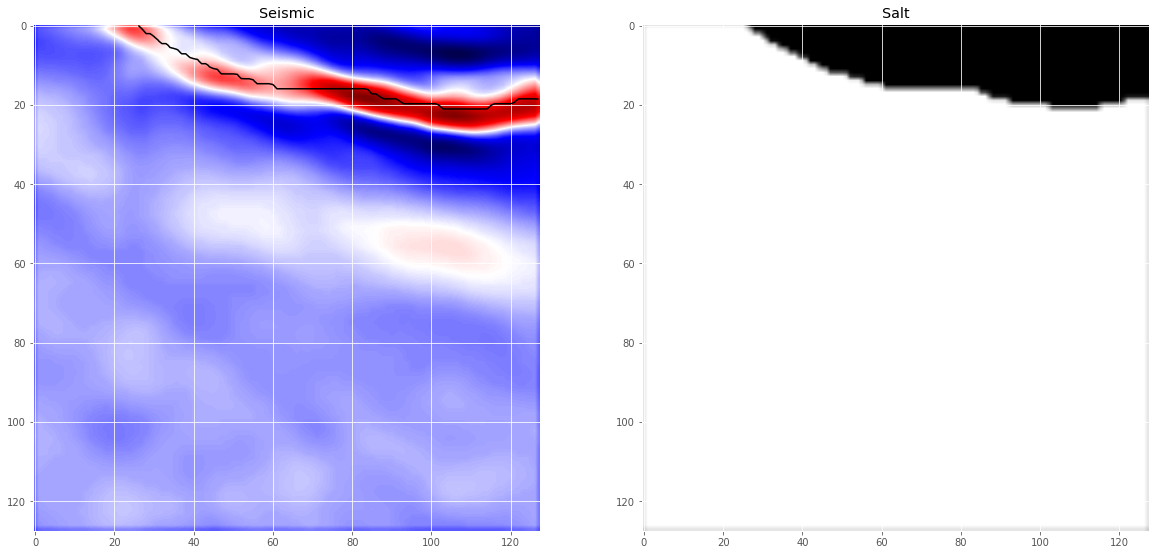

In [6]:
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(X_train[ix, ..., 0], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Seismic')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Salt');

In [0]:
def conv2dblock(input_tensor,n_filters,kernel_size = 3,batchnorm=True):
    
    x = Conv2D(filters=n_filters,kernel_size =(kernel_size,kernel_size),kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(filters=n_filters,kernel_size =(kernel_size,kernel_size),kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    return x

    

In [0]:
def get_unet(input_img,n_filters=16,dropout=0.5,batchnorm=True):
    c1 = conv2dblock(input_img,n_filters=n_filters*1,kernel_size=3,batchnorm=batchnorm)
    p1 = MaxPooling2D((2,2))(c1)
    p1 = Dropout(dropout*0.5)(p1)
    
    c2 = conv2dblock(p1,n_filters=n_filters*2,kernel_size=3,batchnorm=batchnorm)
    p2 = MaxPooling2D((2,2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2dblock(p2,n_filters=n_filters*4,kernel_size=3,batchnorm=batchnorm)
    p3 = MaxPooling2D((2,2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2dblock(p3,n_filters=n_filters*8,kernel_size=3,batchnorm=batchnorm)
    p4 = MaxPooling2D((2,2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2dblock(p4,n_filters=n_filters*16,kernel_size=3,batchnorm=batchnorm)
    
    u6 = Conv2DTranspose(n_filters*8,(3,3),strides=(2,2),padding="same")(c5)
    u6 = concatenate([u6,c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2dblock(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    
    u7 = Conv2DTranspose(n_filters*8,(3,3),strides=(2,2),padding="same")(c6)
    u7 = concatenate([u7,c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2dblock(u7, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    
    u8 = Conv2DTranspose(n_filters*8,(3,3),strides=(2,2),padding="same")(c7)
    u8 = concatenate([u8,c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2dblock(u8, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    
    u9 = Conv2DTranspose(n_filters*8,(3,3),strides=(2,2),padding="same")(c8)
    u9 = concatenate([u9,c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2dblock(u9, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [42]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 128, 128, 16) 64          conv2d_19[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 128, 128, 16) 0           batch_normalization_18[0][0]     
____________________________________________________________________________________________

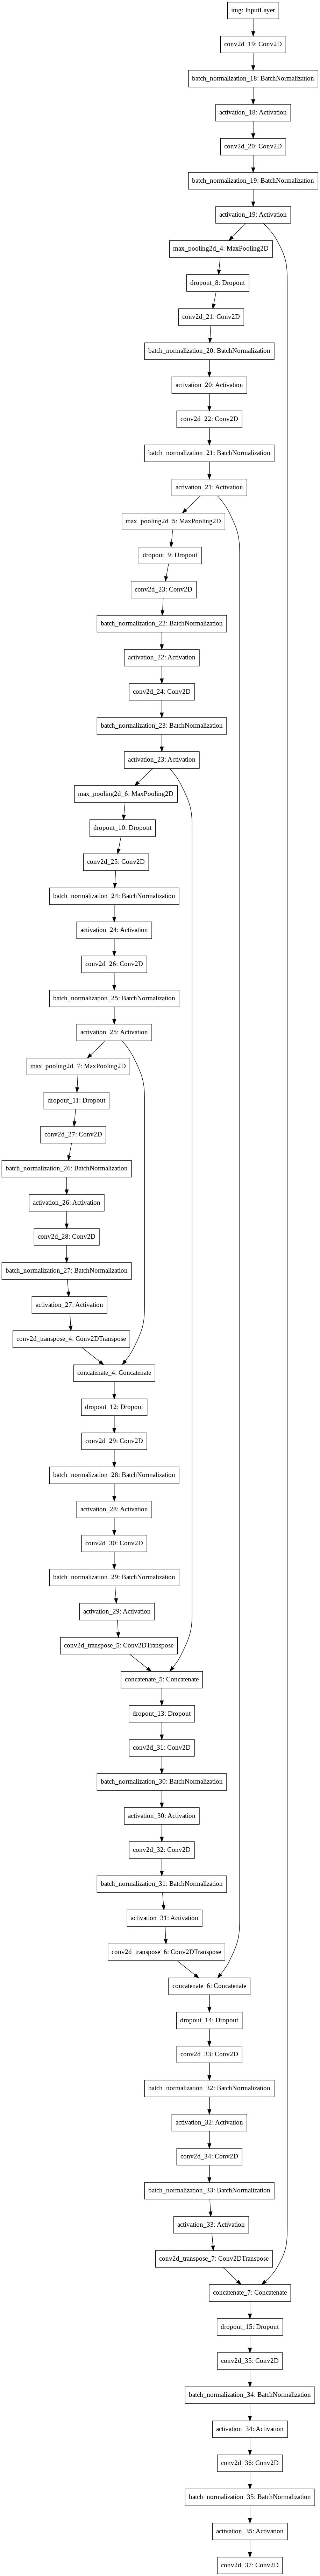

In [43]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [0]:
tbCallBack = TensorBoard(log_dir='./log', histogram_freq=1,
                         write_graph=True,
                         write_grads=True,
                         batch_size=32,
                         write_images=True)

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True),
  
]

In [45]:
results = model.fit(X_train, y_train, batch_size=32, epochs=100, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))

Train on 3400 samples, validate on 600 samples
Epoch 1/100
3392/3400 [============================>.] - ETA: 0s - loss: 0.3927 - acc: 0.8309
Epoch 00001: val_loss improved from inf to 6.82879, saving model to model-tgs-salt.h5
3400/3400 [==============================] - 53s 15ms/sample - loss: 0.3929 - acc: 0.8307 - val_loss: 6.8288 - val_acc: 0.3682
Epoch 2/100
3392/3400 [============================>.] - ETA: 0s - loss: 0.3042 - acc: 0.8762
Epoch 00002: val_loss improved from 6.82879 to 2.00928, saving model to model-tgs-salt.h5
3400/3400 [==============================] - 47s 14ms/sample - loss: 0.3039 - acc: 0.8764 - val_loss: 2.0093 - val_acc: 0.5422
Epoch 3/100
3392/3400 [============================>.] - ETA: 0s - loss: 0.2680 - acc: 0.8877
Epoch 00003: val_loss improved from 2.00928 to 0.80248, saving model to model-tgs-salt.h5
3400/3400 [==============================] - 47s 14ms/sample - loss: 0.2676 - acc: 0.8880 - val_loss: 0.8025 - val_acc: 0.7281
Epoch 4/100
3392/3400 [=

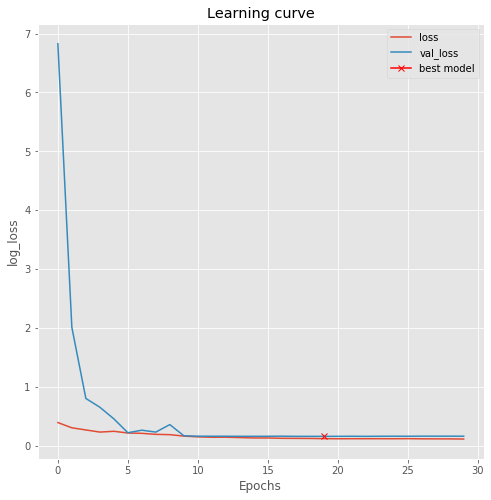

In [46]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [47]:
X_= get_data(test_path,train=False)

Getting and Resizing images ...


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '



Done!


In [0]:
model.load_weights('model-tgs-salt.h5')

In [19]:
pred_test = model.predict(X_,verbose=1)

18000/18000 [==============================] - 67s 4ms/sample


In [0]:
pred_test_t = (pred_test > 0.5).astype(np.uint8)

In [0]:
def plot_masks(X,preds,ix=None):
  if ix is None:
        ix = random.randint(0, len(X))

  has_mask = preds[ix].max() > 0

  fig,ax = plt.subplots(1,2,figsize=(20,10))
  ax[0].imshow(X[ix,...,0],cmap='seismic')
    
  ax[0].set_title('Seismic')

  ax[1].imshow(preds[ix].squeeze())
  ax[1].set_title('Salt')




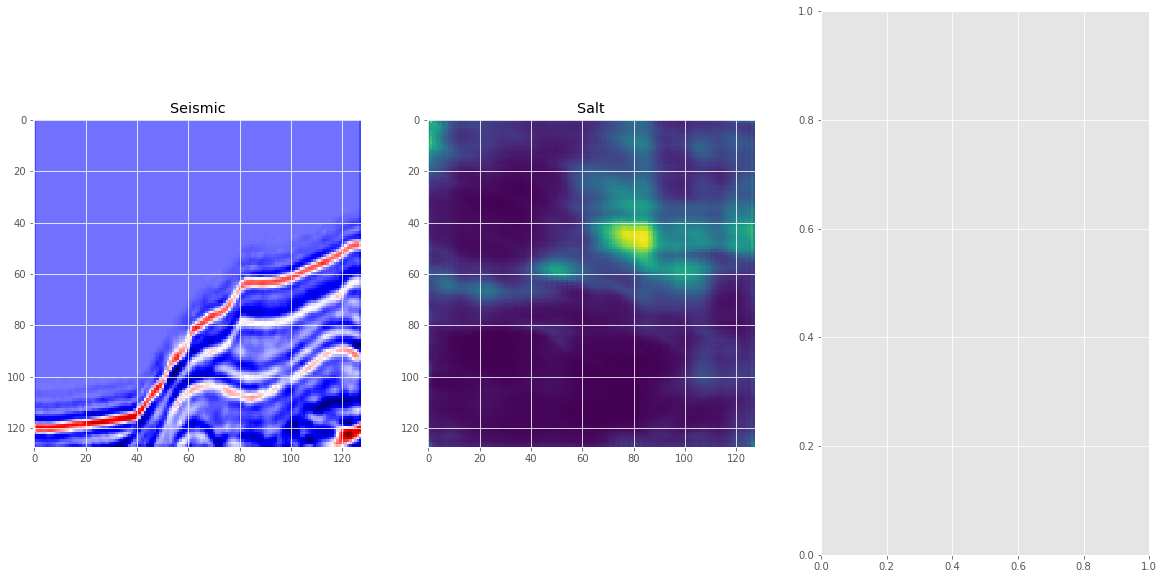

In [30]:
plot_masks(X,pred_test,ix=14)

In [0]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

In [50]:
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

600/600 [==============================] - 2s 4ms/sample


In [51]:
model.evaluate(X_valid, y_valid, verbose=1)

600/600 [==============================] - 2s 4ms/sample - loss: 0.1587 - acc: 0.9294


[0.15870323727528254, 0.9294127]

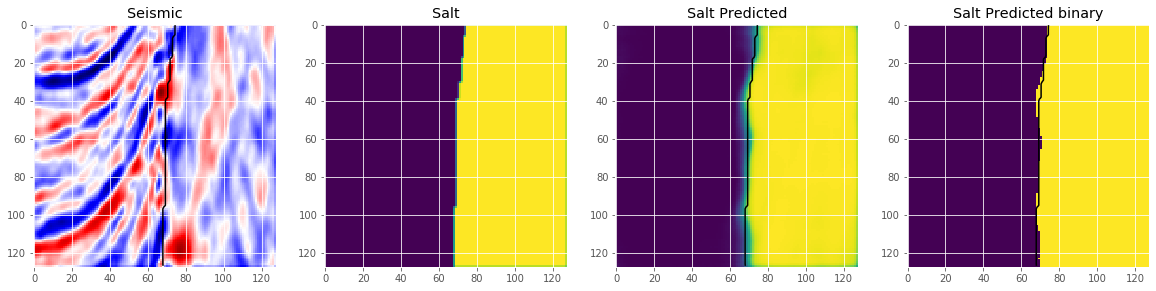

In [57]:
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=107)